postazione
0
0
postazione
0
1
postazione
0
2
postazione
0
3
postazione
1
0
postazione
1
1
postazione
1
2
postazione
1
3
postazione
2
0
postazione
2
1
postazione
2
2
postazione
2
3
postazione
3
0
postazione
3
1
postazione
3
2
postazione
3
3
postazione
4
0
postazione
4
1
postazione
4
2
postazione
4
3
postazione
5
0
postazione
5
1
postazione
5
2
postazione
5
3
postazione
6
0
postazione
6
1
postazione
6
2
postazione
6
3
postazione
7
0
postazione
7
1
postazione
7
2
postazione
7
3
postazione
8
0
postazione
8
1
postazione
8
2
postazione
8
3
postazione
9
0
postazione
9
1
postazione
9
2
postazione
9
3
postazione
10
0
postazione
10
1
postazione
10
2
postazione
10
3
postazione
11
0
postazione
11
1
postazione
11
2
postazione
11
3
postazione
12
0
postazione
12
1
postazione
12
2
postazione
12
3
postazione
13
0
postazione
13
1
postazione
13
2
postazione
13
3
postazione
14
0
postazione
14
1
postazione
14
2
postazione
14
3
postazione
15
0
postazione
15
1
postazione
15
2
postazione
15
3
postazione
16
0


<Figure size 640x480 with 0 Axes>

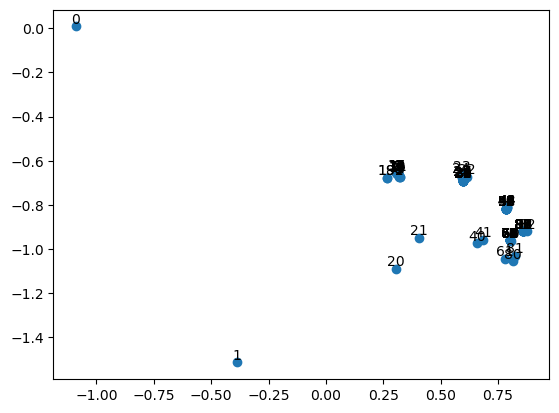

In [55]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import json

def motion_model(particle):
    #Implement the motion model to predict next position
    #We will assume a constant velocity + noise approach
    global linear_vel
    global angular_vel
    #Define noise
    per_xy = 0.1
    per_theta = 0.1
    mu_xy=0
    sigma_x=abs(linear_vel*dt*per_xy)
    sigma_y=abs(linear_vel*dt*per_xy)
    mu_theta=0
    sigma_theta=abs(angular_vel*dt*per_theta)
    noise_x = np.random.normal(mu_xy,sigma_x)
    noise_y = np.random.normal(mu_xy,sigma_y)
    noise_theta=np.random.normal(mu_theta,sigma_theta)
    #Define the matrices for motion model
    matrixA=np.array([[1,0,0],
                      [0,1,0],
                      [0,0,1]])
    arrayB=np.array([linear_vel*dt*math.cos(particle['pose'][2]+math.pi/200),
                     linear_vel*dt*math.sin(particle['pose'][2]+math.pi/200),
                     angular_vel*dt])
    arrayNoise=np.array([noise_x,noise_y,noise_theta])
    #Update the new position
    pose_array=np.array(particle['pose'])#Turns the pose of the particle into an array for matrix multiplication
    new_pose= matrixA @ pose_array + arrayB + arrayNoise
    x,y,theta = new_pose
    particle['pose'] = [x,y,theta]
    #Return the new particle with the new 'pose'
    return particle

def noisy_motion(noisy_position):
    mu_xy=0
    sigma_xy=0.1
    mu_theta=0
    sigma_theta=0.1
    noise_x = np.random.normal(mu_xy,sigma_xy)
    noise_y = np.random.normal(mu_xy,sigma_xy)
    noise_theta=np.random.normal(mu_theta,sigma_theta)
    
    matrixA=np.array([[1,0,0],
                      [0,1,0],
                      [0,0,1]])
    arrayB=np.array([linear_vel*dt*math.cos(noisy_position[2]+math.pi/200),
                     linear_vel*dt*math.sin(noisy_position[2]+math.pi/200),
                     angular_vel*dt])
    arrayNoise=np.array([noise_x,noise_y,noise_theta])
    noisy_new_pose= matrixA @ noisy_position + arrayB+ arrayNoise
    return noisy_new_pose


def ideal_motion(ideal_position):
    matrixA=np.array([[1,0,0],
                      [0,1,0],
                      [0,0,1]])
    arrayB=np.array([linear_vel*dt*math.cos(ideal_position[2]+math.pi/200),
                     linear_vel*dt*math.sin(ideal_position[2]+math.pi/200),
                     angular_vel*dt])
    ideal_new_pose= matrixA @ ideal_position + arrayB
    return ideal_new_pose

def pi_2_pi(angle):
    return (angle + math.pi) % (2 * math.pi) - math.pi



def h_inverse(particle,z):
    alpha=z[2]
    d=z[1]
    mu_x=particle['pose'][0] + d*math.cos(alpha + particle['pose'][2] - math.pi/2)
    mu_y=particle['pose'][1] + d*math.sin(alpha + particle['pose'][2] - math.pi/2)
    return mu_x, mu_y

def h_function(x,y,theta,mu_x,mu_y):
    dx=mu_x-x
    dy=mu_y-y
    d=math.sqrt(dx**2+dy**2)
    thet=pi_2_pi(-theta + math.atan2(dy,dx))
    meas=np.array([d,thet])
    return meas

def jacobian(x,y,theta,mu_x,mu_y):
    #Define elements to go inside the matrix -> function values and small deviations
    dx=mu_x-x
    dy=mu_y-y
    d=math.sqrt(dx**2+dy**2)
    
    #Define matrix
    H = np.array([[dx/d,dy/d],
               [-dy/pow(d,2),dx/pow(d,2)]])
    
    return H
    
def is_landmark_seen(particle, landmark_id):
    landmarks = particle['landmarks']
    if landmarks:
        return any(landmark['id'] == landmark_id for landmark in landmarks)
    else:
        return False

def initialize_landmark(particle,z,err,landmark_id):
    new_landmark=[]
    mu=h_inverse(particle,z)
    H=jacobian(particle['pose'][0],particle['pose'][1],particle['pose'][2],mu[0],mu[1])
    Q=np.eye(2)*err
    sigma= np.linalg.inv(H) @ Q @np.transpose(np.linalg.inv(H))
    new_landmark={
        'id':landmark_id,
        'mu':mu,
        'sigma':sigma,
     }
    return new_landmark
    
def update_landmark(particle, landmark_id, z, err):
    #We just want to alter the landmark whose id matches the landmark_id
    landmarks=particle['landmarks']
    for i,landmark in enumerate(landmarks):
        if landmark['id']==landmark_id:
            index=i
            break
    
    mu_old=particle['landmarks'][index]['mu']
    sigma_old=particle['landmarks'][index]['sigma']
    z_hat=h_function(particle['pose'][0],particle['pose'][1],particle['pose'][2],mu_old[0],mu_old[1])
    H = jacobian(particle['pose'][0],particle['pose'][1],particle['pose'][2],mu_old[0],mu_old[1])
    Q=H @ sigma_old @ np.transpose(H) + np.eye(2)*err
    K= sigma_old @ np.transpose(H) @ np.linalg.inv(Q)
    # print(K)
    #Create array (our z contains (id,d, theta) whereas our z_hat contains (d,theta))
    z_deviation=np.array([z[1]-z_hat[0],z[2]-z_hat[1]])
    z_deviation[1]=pi_2_pi(z_deviation[1])
    #print(z_deviation)
    mu_new = mu_old + K @ z_deviation
    sigma_new= (np.eye(2) - K@H) @ sigma_old
    Qdet=np.linalg.det(Q)
    num=math.exp(-1/2*np.transpose(z_deviation) @ np.linalg.inv(Q) @ z_deviation)
    den=2*np.pi*math.sqrt(Qdet)
    new_weight=num/den
    # print(f"NEW WEIGHT {new_weight} {Qdet} {z_deviation} {Q}")

    #Apply the new values to the respective landmark and the new weight to the particle
    particle['weight'] = new_weight
    particle['landmarks'][index]['mu']=mu_new
    particle['landmarks'][index]['sigma']=sigma_new

    return(particle)

def normalize_weights(ParticleSet_var):
    #Normalize the weights
    total_weight=0
    for particle in ParticleSet_var:
        total_weight=total_weight+float(particle['weight'])

    for particle in ParticleSet_var:
        particle['weight'] = float(particle['weight']) / total_weight
    
    return (ParticleSet_var)

def resample_particles(ParticleSet,num_particles):
    #THE WEIGHTS IN THE PARTICLES SHOULD BE NORMALIZED
    weights=[]
    indices=[]
    num_landmarks = len(ParticleSet[0]['landmarks'])
    for i in range(num_particles):
        weights.append(ParticleSet[i]['weight'])
    indices=np.arange(num_particles)
    resampled_indices=np.random.choice(indices,size=num_particles,p=weights)
    new_particle_set=[]
    
    for i in resampled_indices:
        x=ParticleSet[i]['pose'][0]
        y=ParticleSet[i]['pose'][1]
        theta=ParticleSet[i]['pose'][2]
        new_particle={
        'pose': [x,y,theta],
        'landmarks': [],
        'weight': base_weight}
        #Loop for each landmark
        for j in range(num_landmarks):
           id=ParticleSet[i]['landmarks'][j]['id']
           mu=ParticleSet[i]['landmarks'][j]['mu']
           sigma=ParticleSet[i]['landmarks'][j]['sigma']
           new_landmark={
            'id': id, #Assuming we use the ids in order, i.e, if we use 5 markers, we are using those which have id=0,1,2,3,4
            'mu': mu,
            'sigma': sigma
            }
           new_particle['landmarks'].append(new_landmark)
           
        #Add the new_particle to the new_particle_set variable
        new_particle_set.append(new_particle)

    return (new_particle_set)


def find_sigma(ParticleSet,weights, n_land):
    landmark_variances_x=[[] for _ in range(len(ParticleSet))] #Creates a list of empty lists. Each of these lists correspond to the variance of a landmark
    landmark_variances_y=[[] for _ in range(len(ParticleSet))]
    landmark_variances_xy=[[] for _ in range(len(ParticleSet))]
    i=0
    for particle in ParticleSet:
        landmark=particle['landmarks'][n_land]
        landmark_sigma_x=landmark['sigma'][0][0]
        landmark_sigma_y=landmark['sigma'][1][1]
        landmark_sigma_xy=landmark['sigma'][0][1]
        landmark_variances_x[i].append(landmark_sigma_x)
        landmark_variances_y[i].append(landmark_sigma_y)
        landmark_variances_xy[i].append(landmark_sigma_xy)
        i=i+1

    weighted_sigma_x=np.average(landmark_variances_x,axis=0,weights=weights)
    weighted_sigma_y=np.average(landmark_variances_y,axis=0,weights=weights)
    weighted_sigma_xy=np.average(landmark_variances_xy,axis=0,weights=weights)
        
    weighted_sigma=np.array([[weighted_sigma_x,weighted_sigma_xy ],[weighted_sigma_xy,weighted_sigma_y]])

    return weighted_sigma




def retrieve_landmark_positions(ParticleSet,weights):
    num_landmarks=len(ParticleSet[0]['landmarks']) #Every particle has ALWAYS the same number of landmarks
    landmark_positions=[[] for _ in range(num_landmarks)] #Creates a list of empty lists. Each of these lists correspond to a landmark

    for particle in ParticleSet:
        landmarks=particle['landmarks']
        for i,landmark in enumerate(landmarks):
            landmark_mean=landmark['mu']
            landmark_positions[i].append(landmark_mean)

    weighted_landmark_positions=[]
    for landmark in landmark_positions:
        landmark=np.array(landmark)
        weighted_mean=np.average(landmark,axis=0,weights=weights)
        weighted_landmark_positions.append(weighted_mean.tolist())

    return weighted_landmark_positions

def fastslam_kc(ParticleSet,num_particles,measurements):
    for k in range(num_particles):
        #Sample new pose -> Motion Model
        ParticleSet[k]=motion_model(ParticleSet[k])
        #Loop in the number of observations done in each instant 
        #(there might be a possibility that the robot does multiple observations at the same instant)
        for i in range(len(measurements)):
            landmark_id=measurements[i][0]
            #See if landmark as been seen
            if not is_landmark_seen(ParticleSet[k],landmark_id):
                new_landmark=[]
                new_landmark=initialize_landmark(ParticleSet[k],measurements[i],err,landmark_id)
                ParticleSet[k]['landmarks'].append(new_landmark)
                ParticleSet[k]['weight'] = base_weight
            else:
                ParticleSet[k]=update_landmark(ParticleSet[k],landmark_id,measurements[i],err)


    ParticleSet=normalize_weights(ParticleSet)
    #Take robot's position and landmark position
    weights=np.array([particle['weight'] for particle in ParticleSet])
    poses=np.array([particle['pose'] for particle in ParticleSet])
    pose_estimate=np.average(poses,axis=0,weights=weights)
    landmarks_estimate=retrieve_landmark_positions(ParticleSet,weights)

    #Resample particles
    ParticleSet=resample_particles(ParticleSet,num_particles)
    return ParticleSet,pose_estimate,landmarks_estimate #for each t

def plot_robot_pose_and_landmarks(robot_positions, landmarks_pose):

    #Extract correctly the robot's positions (over all time -> Path)
    robot_x=[robot_positions[i][0] for i in range(len(robot_positions))]
    robot_y=[robot_positions[i][1] for i in range(len(robot_positions))]

    #Extract correctly the landmark positions(at last iteration -> Final landmark positions)
    landmark_x=[landmark[0] for landmark in landmarks_pose]
    landmark_y=[landmark[1] for landmark in landmarks_pose]

    #Plot the robot's position
    plt.scatter(robot_x,robot_y,color='blue', label='Robot Path')

    #Plot the landmarks positions
    plt.scatter(landmark_x,landmark_y,color='red',label='Landmarks')

    #Add labels
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.savefig('SLAM.png')
    plt.clf()

    

    
def plot_confidence_ellipse(ax, landmark_position, landmark_cov, n_std=1.0):
    x, y = landmark_position
    pearson = landmark_cov[0, 1]/np.sqrt(landmark_cov[0, 0] * landmark_cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 1, height=ell_radius_y * 1, edgecolor='red', facecolor='none')

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(landmark_cov[0, 0]) * n_std

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(landmark_cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(x, y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)    
    
    
    
    
def plot_poses_and_ellipses(landmarks_position, robot_positions, ParticleSet, ideal_positions, noisy_positions):
    fig, ax = plt.subplots()
    #Extract correctly the robot's positions (over all time -> Path for FASTSLAM)
    robot_x=[robot_positions[i][0] for i in range(len(robot_positions))]
    robot_y=[robot_positions[i][1] for i in range(len(robot_positions))]
    
    #Extract correctly the landmark positions(at last iteration -> weighted Final landmark positions)
    landmark_x=[landmark[0] for landmark in landmarks_pose]
    landmark_y=[landmark[1] for landmark in landmarks_pose]
    
    #Extract correctly the ideal position of the robot (over all time -> Ideal path)
    ideal_x=[ideal_positions[i][0] for i in range(len(ideal_positions))]
    ideal_y=[ideal_positions[i][1] for i in range(len(ideal_positions))]
    
    #Extract correctly the position following odometry of the robot (over all time -> Odometry path, motion model considering error)
    #odom_x=[noisy_positions[i][0] for i in range(len(noisy_positions))]
    #odom_y=[noisy_positions[i][1] for i in range(len(noisy_positions))]
    
    #Plot the robot's position
    ax.scatter(robot_x,robot_y,color='blue', label='Robot Path for FASTSLAM')

    #Plot the landmarks positions
    ax.scatter(landmark_x,landmark_y,color='black',label='Landmarks')

    #Plot the real robot path
    ax.scatter(ideal_x,ideal_y,color='green',label='Real path')
    
    #Plot the real robot path
    #ax.scatter(odom_x,odom_y,color='red',label='Odometry path')
    
    weights=np.array([particle['weight'] for particle in ParticleSet])
    for i in range(len(landmark_x)):
        
        x=landmark_x[i]
        y=landmark_y[i]
        land_pos=np.array([x,y])
        cov=find_sigma(ParticleSet,weights, i)
        plot_confidence_ellipse(ax, land_pos, cov, n_std=1.0)
        
    #Add labels
    plt.xlabel('X')
    plt.ylabel('Y')
    ax.legend()
    plt.savefig('SLAM_Ellipses.png')
    plt.clf()

    
    
    
    
    
    
    
    
#Some parameters to define, such as timestep, linear_vel and angular_vel
n_turns = 5
r = 2
turn_t = 20
angular_vel=2*math.pi/turn_t
linear_vel=r*math.sqrt(2*(1-math.cos(angular_vel*0.1)))/0.1
precision=0.1
err=0.01

#Define the range for each dimension
x_min=-0
x_max=0
y_min=-0
y_max=0
theta_min=0 # math.pi/2-math.pi/12
theta_max=0 #math.pi/2+math.pi/12

#Initiate the ParticleSet:
num_particles=1000
base_weight=1/num_particles
#num_landmarks=5 #Put here the number of the landmarks. We should know their id and it should be by order.
ParticleSet=[] #Holds each particle. Each particle is a dictionary that should have 'pose' and 'landmarks'.
                #The 'pose' section has a list of 3 variables (x,y,theta)
                #The landmarks section has, for each landmark, a list for the 'mu' and a matrix 'sigma'

#We assume a random uniform distribution for the robot's pose in the particles. 
#We don't initialize mean values nor covariances for the landmarks because the robot has not yet detected them
for i in range(num_particles):
    x=random.uniform(x_min,x_max)
    y=random.uniform(y_min,y_max)
    theta=random.uniform(theta_min,theta_max)
    new_particle={
        'pose': [x,y,theta],
        'landmarks': [],
        'weight': base_weight}
    
    #Add the new_particle to the particle_set variable
    ParticleSet.append(new_particle)
    

#Create list for all the positions of the robot
robot_positions=[]
land_int = []
ideal_positions=[]
noisy_positions=[]
ideal_new_position=np.array([0,0,0])
noisy_new_position=np.array([0,0,0])

with open("simulation.json", "r") as file_json:
    data = json.load(file_json)

old_time = -1

#Iterate over the messages in the bag file
for i in range(len(data)):
    measurements=[]

    if old_time == -1:
        dt = 1
    else:
        current_time = data["obs"+str(i)]["time"]
        dt = current_time-old_time
        old_time = current_time

    for j in range(len(data["obs"+str(i)])-1):
        print("postazione\n"+str(i)+"\n"+str(j))
        fiducial_id = data["obs"+str(i)]["land"+str(j)]["id"]
        translation_x = data["obs"+str(i)]["land"+str(j)]["x"]
        translation_y = data["obs"+str(i)]["land"+str(j)]["y"]
        d=math.sqrt(translation_x**2+translation_y**2)
        theta=pi_2_pi( - math.atan2(translation_y,translation_x))
        
        #Add the landmark measurements to a variable. In this case we are not discarding the possibility of the robot detecting more than one aruco marker
        measurements.append([fiducial_id,d,theta])
        length=len(measurements)
        ideal_new_position=ideal_motion(ideal_new_position)
        noisy_new_position=noisy_motion(noisy_new_position)
        
    ParticleSet,pose_estimate, landmarks_pose = fastslam_kc(ParticleSet,num_particles, measurements)
    land_int.append(landmarks_pose[3])
    robot_positions.append(pose_estimate)
    ideal_positions.append(ideal_new_position)
    noisy_positions.append(noisy_new_position)
    
plot_robot_pose_and_landmarks(robot_positions,landmarks_pose)
plot_poses_and_ellipses(landmarks_pose, robot_positions, ParticleSet, ideal_positions, noisy_positions)

plt.figure(1)
plt.scatter([land_int[i][0] for i in range(len(land_int))], [land_int[i][1] for i in range(len(land_int))])
labels = [str(i) for i in range(len(land_int))]
for j in range(len(land_int)):
    plt.text(land_int[j][0], land_int[j][1], labels[j], ha='center', va='bottom')
plt.show()

In [49]:

plot_poses_and_ellipses(landmarks_pose, robot_positions, ParticleSet, ideal_positions, noisy_positions)

<Figure size 640x480 with 0 Axes>